In [1]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir


In [4]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict = {k:v for k,v in zip(AGENTS, AGENTS_CLEAN_NAMES)}



In [5]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [27]:
#game_states[0].game_state

In [112]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def from_pandas_to_aggregation(new_df):
    df_copy = new_df.copy()
    df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
    df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)
    
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    df_copy['models'] = df_copy['models'].apply(lambda v: "@".join(sorted(v.split('@'))))
    
    # swap cells which are re-ordered
    to_swap = df_copy['model_1'] > df_copy['model_2'] 
    temp = df_copy['resource_delta_1'][to_swap].copy()
    df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
    df_copy['resource_delta_2'][to_swap] = temp
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] =df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 'models'])[[ 'win_1', 'win_2', 'resource_delta_1', 'resource_delta_2']].agg(['mean',]).reset_index()
    
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    win_rates = df_copy["win_1"]["mean"].tolist() + df_copy["win_2"]["mean"].tolist()
    payoffs = df_copy["resource_delta_1"]["mean"].tolist() + df_copy["resource_delta_2"]["mean"].tolist()
    model1 = df_copy["model_1"].tolist() + df_copy["model_2"].tolist()
    model2  = df_copy["model_2"].tolist() + df_copy["model_1"].tolist()
    
    aggregated = pd.DataFrame({"winrate" : win_rates, "payoff" : payoffs, "model_1" : model1, "model_2" : model2})
    return aggregated


def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)
    
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior, original_valuations), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2"])

    return df


# Section One

## Trading

In [14]:
log_dir = "../experiments/section_one/.logs/trading_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)
aggregated = from_pandas_to_aggregation(df)


THERE ARE 471 log files
471 Loaded Successfully


### WinRate

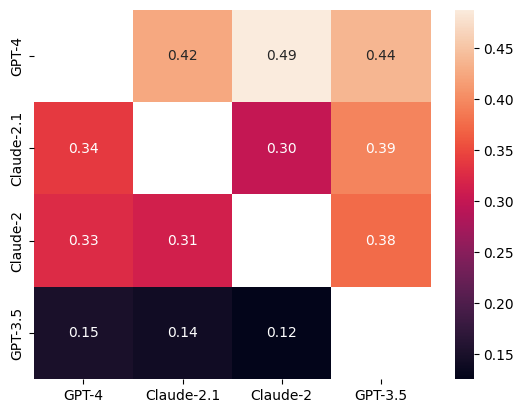

In [10]:
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="winrate")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_trading_winrate.pdf") 

### Payoff

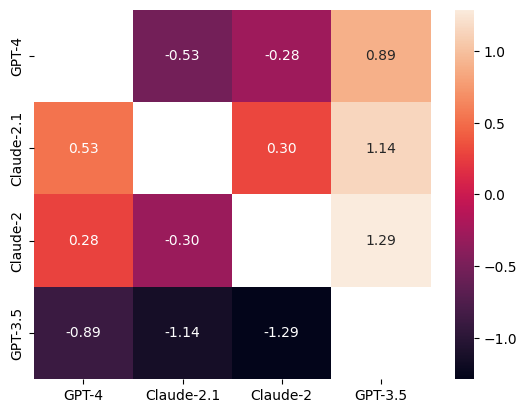

In [19]:
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="payoff")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)

mask = np.eye(local_aggregate.values.shape[0], dtype=bool)
local_aggregate =local_aggregate.fillna(1)

g2 = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f")
g2.set(ylabel=None)
g2.set(xlabel=None)

g2.get_figure().savefig("figures/section_one_trading_payoff.pdf") 


## Ultimatum

In [20]:
log_dir = "../experiments/section_one/.logs/ultimatum_multi_section_one/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)
df["resource_delta_1"] = df["resource_delta_1"] + 100
aggregated = from_pandas_to_aggregation(df)


THERE ARE 240 log files
240 Loaded Successfully


### Win Rate

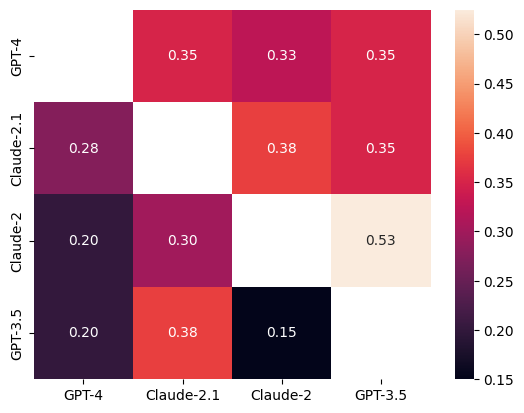

In [22]:

local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="winrate")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_ultimatum_winrate.pdf") 

### PayOff

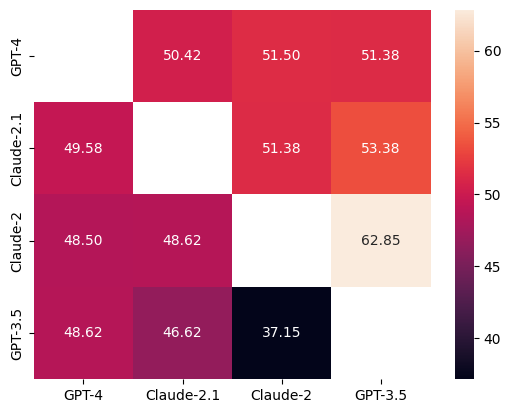

In [23]:
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="payoff")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)

mask = np.eye(local_aggregate.values.shape[0], dtype=bool)
local_aggregate =local_aggregate.fillna(1)

g2 = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f")
g2.set(ylabel=None)
g2.set(xlabel=None)

g2.get_figure().savefig("figures/section_one_ultimatum_payoff.pdf") 


## Buy Sell

In [106]:
log_dir = "../experiments/section_one/.logs/buysell_section_one/"
#game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)


### BuySell Win Rates

In [107]:
df["vals1"] = df["vals1"].apply(lambda x : x.valuation_dict["X"])
df["vals2"] = df["vals2"].apply(lambda x : x.valuation_dict["X"])


In [108]:
gb = df.groupby('vals1')    
seller_at_40, seller_at_60 = [gb.get_group(x).copy() for x in gb.groups]

/tmp/ipykernel_7099/3210237997.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
/tmp/ipykernel_7099/3210237997.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_2'][to_swap] = temp


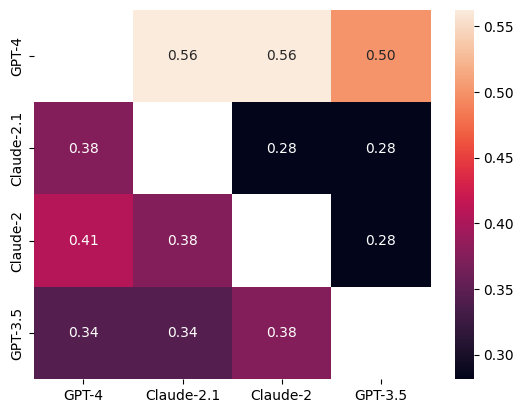

In [113]:
aggregated = from_pandas_to_aggregation(seller_at_40)
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="winrate")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_buy_sell_winrate_seller_40.pdf") 

/tmp/ipykernel_7099/3210237997.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
/tmp/ipykernel_7099/3210237997.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_2'][to_swap] = temp


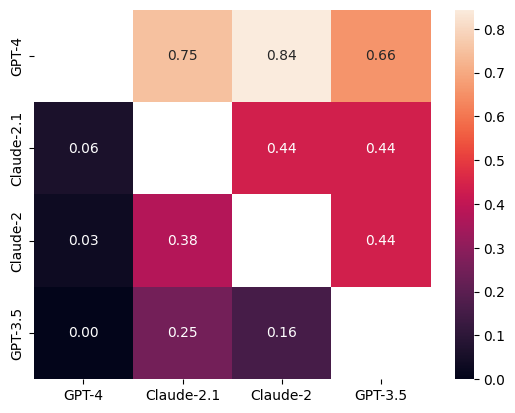

In [114]:
aggregated = from_pandas_to_aggregation(seller_at_60)
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="winrate")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_buy_sell_winrate_seller_60.pdf") 

### Payoff

/tmp/ipykernel_7099/3210237997.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
/tmp/ipykernel_7099/3210237997.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_2'][to_swap] = temp


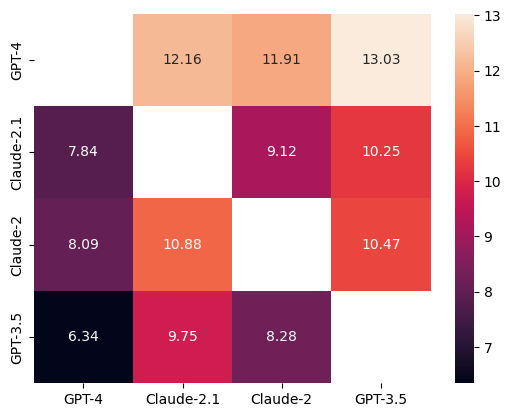

In [115]:
aggregated = from_pandas_to_aggregation(seller_at_40)
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="payoff")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_buy_sell_payoff_seller_40.pdf") 

/tmp/ipykernel_7099/3210237997.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
/tmp/ipykernel_7099/3210237997.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['resource_delta_2'][to_swap] = temp


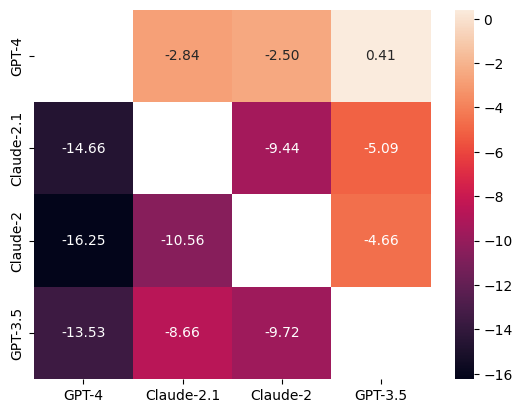

In [116]:
aggregated = from_pandas_to_aggregation(seller_at_60)
local_aggregate = aggregated.pivot(index="model_1", columns="model_2", values="payoff")

local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES, axis=1)
local_aggregate = local_aggregate.reindex(AGENTS_CLEAN_NAMES)
mask = np.eye(local_aggregate.values.shape[0], dtype=bool)

figu = sns.heatmap(local_aggregate, annot=True, mask=mask, fmt=".2f", yticklabels=AGENTS_CLEAN_NAMES, xticklabels=AGENTS_CLEAN_NAMES)
figu.set(ylabel=None)
figu.set(xlabel=None)
fig = figu.get_figure()
fig.savefig("figures/section_one_buy_sell_payoff_seller_60.pdf") 